In [2]:
import keras
import cv2
import os
import numpy as np
from tqdm import tqdm
from io import BytesIO
from keras import backend as K
from keras.layers import Dense, UpSampling2D, Conv2D, Input, Reshape
from keras.layers import Input, Conv2D, Dense, Flatten, LeakyReLU, Activation, Dropout
from keras.layers import Layer, Reshape, Conv2DTranspose, Lambda, ReLU, BatchNormalization, Concatenate
from keras.models import Model
from keras.optimizers import Adam
import random 
import pandas as pd
from matplotlib import pyplot as plt
try:
  from livelossplot import PlotLossesKeras
except:
  !pip install livelossplot
  from livelossplot import PlotLossesKeras
import inspect
import pathlib

Using TensorFlow backend.


## Descarga y lectura de los datos

In [3]:
data_path = keras.utils.get_file(
    "train.zip",
    "https://hdvirtual.us.es/discovirt/index.php/s/GNSEexkg2Wq4BXd/download",
    extract=True,
    archive_format='zip'
)

DATA_FOLDER = pathlib.Path(data_path).parent

img_folder = os.path.join(DATA_FOLDER, 'train_img')
strokes_csv = os.path.join(DATA_FOLDER, 'train_strokes.csv')    
    
strokes = pd.read_csv(strokes_csv)

In [4]:
strokes.head()

,alpha,bristleCount,fluidity,hue,num_steps,file_name,saturation,scale,value,x1,x2,x3,y1,y2,y3,stroke_id
0,0.326438,13,0.743923,0.333411,6,PAINT_VZJ1KXF5_stroke_3.png,0.914306,12,0.773216,54,176,168,2,17,111,5404
1,0.326438,13,0.743923,0.333411,6,PAINT_OSW1A4_A_stroke_1.png,0.914306,12,0.773216,54,176,168,2,17,111,5404
2,0.326438,13,0.743923,0.333411,6,PAINT_67EN3H9X_stroke_2.png,0.914306,12,0.773216,54,176,168,2,17,111,5404
3,0.326438,13,0.743923,0.333411,6,PAINT_91_D8ZTS_stroke_4.png,0.914306,12,0.773216,54,176,168,2,17,111,5404
4,0.326438,13,0.743923,0.333411,6,PAINT_LYHYHXKG_stroke_0.png,0.914306,12,0.773216,54,176,168,2,17,111,5404


In [5]:
strokes.describe()

,alpha,bristleCount,fluidity,hue,num_steps,saturation,scale,value,x1,x2,x3,y1,y2,y3,stroke_id
count,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000,58778.000000
mean,0.501484,14.943465,0.699873,0.499520,6.503318,0.667951,14.995696,0.748447,99.617731,100.162084,100.596363,100.635680,99.878577,99.685512,8406.694852
std,0.288065,3.158792,0.057700,0.287762,2.299133,0.235988,6.061879,0.194750,58.236869,58.062148,57.711171,58.260095,57.800894,57.733900,4854.591618
min,0.000075,10.000000,0.600012,0.000005,3.000000,0.011724,5.000000,0.039602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.252296,12.000000,0.649385,0.252637,4.000000,0.498380,10.000000,0.631165,49.000000,50.000000,51.000000,50.000000,50.000000,50.000000,4190.000000
50%,0.501490,15.000000,0.699953,0.496397,7.000000,0.709688,15.000000,0.791642,100.000000,100.000000,101.000000,101.000000,100.000000,98.000000,8382.000000
75%,0.751770,18.000000,0.749229,0.749826,9.000000,0.867734,20.000000,0.906640,150.000000,151.000000,150.000000,152.000000,149.000000,149.000000,12635.000000
max,0.999914,20.000000,0.799999,0.999859,10.000000,0.999979,25.000000,0.999990,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,16805.000000


In [6]:
def read(_dir):
    
    # obtenemos los nombres de los archivos de imágenes
    file_names = os.listdir(_dir)
    file_names = [file for file in file_names if file.split('.')[-1] != 'csv']
    
    print('Total de imagenes: %d' % len(file_names))
    
    import imageio
    return {f: open(os.path.join(_dir, f), 'rb').read() for f in tqdm(file_names)}

im_bytes = read(img_folder)

  9%|▉         | 5366/58778 [00:00<00:00, 53652.25it/s]

Total de imagenes: 58778


100%|██████████| 58778/58778 [00:01<00:00, 49830.39it/s]


### Generador/Iterador de datos para entrenar la(s) red(es)

Esta clase recibe las imágenes en modo binario (leídas anteriormente) y los parámetros de la pincelada (CSV) así como otros parámetros para configurar el batch: 
 
  - batch_size (int): tamaño del batch.
  - shuffle (bool): si aplicar barajado o no tras cada época.
  - input_shape (tuple): tamaño al que redimensionar las imágenes. 
  - mode (str): tipo de entrada y salida del batch. Este parámetro se debe establecer en función del modelo que se entrene. Hay codificado tres modos:
     - stroke: entrada de la red los parámetros de la pincelada, salida de la red imagen de la pincelada
     - ae: entrada y salida de la red la imágen de la pincelada
     - cae: entrada de la red los parámetros de la pincelada y la imagen y como salida de la red la imagen.

In [7]:
class StrokeInMemoryIterator(keras.utils.Sequence):
       
    def __init__(self, im_bytes, stroke_info, batch_size, shuffle=True,
                 input_shape=(128, 128), mode='stroke'):
        self.im_bytes = im_bytes
        self.stroke_info = stroke_info
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.mode = mode

        self.__len = int(stroke_info.shape[0] / self.batch_size)
        self.__features = ['alpha', 'bristleCount', 'fluidity', 'hue', 'num_steps', 'saturation', 
           'scale', 'value', 'x1', 'x2', 'y1', 'y2', 'x3', 'y3']
        
        self.reset()

    def __len__(self):
        return self.__len

    def __getitem__(self, index):
        # comienzo y final del batch
        i = index * self.batch_size
        j = i + self.batch_size
        
        # indixes del batch
        indexes = self.__indexes[i:j]
        
        # entrada(s) y salida del batch
        info = self.stroke_info.iloc[indexes]
        stroke = info[self.__features].values
        y = [self.im_bytes[f] for f in info.file_name]
        

        # lista final de arrays
        y = self.preprocess_batch(y)
                
   
        # devolvemos el batch
        if self.mode == 'stroke':
            return stroke, y
        elif self.mode == 'ae':
            return y, y
        elif self.mode == 'cae':
            return [np.array(y), np.array(stroke)], y
        
    def preprocess_batch(self, batch):
        ims = []
        for im in batch:
            file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
            im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, self.input_shape) 
            ims.append(im)

        # normalizamos
        ims = np.array(ims).astype('float') / 255
        
        return ims
    
    def on_eponch_end(self):
        self.reset()
        
    def reset(self):
        self.__indexes = list(range(self.stroke_info.shape[0]))           
        if self.shuffle:
            self.__indexes = random.sample(self.__indexes, len(self.__indexes))
        self.__current_index = 0

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        # si hemos llegado al final reiniciamos
        if self.__current_index >= self.__len:
            self.reset()
            
        # cogemos el siguiente batch
        r =  self.__getitem__(self.__current_index)
        
        # incrementamos el indice
        self.__current_index += 1
        
        return r

Como ejemplo vamos a crear un iterador que nos genere batches de 5 muestras para una red que recibirá como entrada los parámetros de la pincelada y como salida la imágen:

In [8]:
it = StrokeInMemoryIterator(im_bytes, strokes, 5, mode='stroke', shuffle=False)

Vamos a tomar el primer batch y ver lo que nos devuelve:

In [9]:
r = it.__next__()

# el primer elemento de la tupla es la entrada de la red
# mostramos la primera muestra
r[0][0]

array([  0.32643782,  13.        ,   0.74392324,   0.33341143,
         6.        ,   0.91430648,  12.        ,   0.77321626,
        54.        , 176.        ,   2.        ,  17.        ,
       168.        , 111.        ])

Vemos que corresponde a los 14 parámetros de la pincelada.

Para mostrar el segundo elemento de la tupla, como son imágenes vamos a usar la función `draw2compare` para mostrarlas:

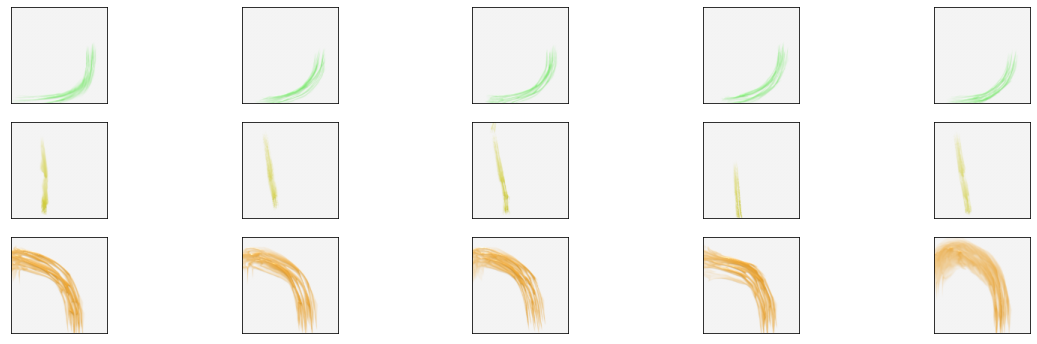

In [ ]:
r2 = it.__next__()
r3 = it.__next__()

def draw2compare(*args):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    for i in range(5):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()
    
draw2compare(r[1], r2[1], r3[1])

def draw2compare(*args):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    for i in range(n):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()
def ssim_loss(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

from keras.models import load_model   
sg = load_model('eric_model_good.h5', custom_objects={"ssim_loss": ssim_loss} )

rows = 3
cols = 10
y = tuple([sg.predict(np.random.uniform(0,1, size=(cols, 10))) for _ in range(rows)])

draw2compare(*y)



In [ ]:
def ssim_loss(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
from keras.models import load_model   
sg = load_model('eric_model_good.h5', custom_objects={"ssim_loss": ssim_loss} )

In [ ]:
sg.summary()